In [2]:
import cv2
import mediapipe as mp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os
from tqdm import tqdm
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime

In [3]:
class HandGestureRecognizer:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.5
        )
        self.model = None
        self.label_encoder = None

    def save_model(self, save_dir):
        """Save model and metadata."""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        # Save model with .keras extension
        model_path = os.path.join(save_dir, 'gesture_model.keras')
        self.model.save(model_path)
        
        # Save label encoder
        with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
            pickle.dump(self.label_encoder, f)
            
        # Save class names
        class_names = self.label_encoder.classes_.tolist()
        with open(os.path.join(save_dir, 'class_names.json'), 'w') as f:
            json.dump(class_names, f)
            
        print(f"Model and metadata saved to {save_dir}")
        
    def load_model(self, save_dir):
        """Load model and metadata."""
        # Load model with .keras extension
        model_path = os.path.join(save_dir, 'gesture_model.keras')
        self.model = tf.keras.models.load_model(model_path)
        
        # Load label encoder
        with open(os.path.join(save_dir, 'label_encoder.pkl'), 'rb') as f:
            self.label_encoder = pickle.load(f)
            
        print(f"Model and metadata loaded from {save_dir}")
        
    def process_image(self, image_path):
        """Process a single image and extract hand landmarks."""
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = self.hands.process(image_rgb)
        
        if not results.multi_hand_landmarks:
            return None
        
        h, w, _ = image.shape
        landmarks = results.multi_hand_landmarks[0].landmark
        
        x_coords = [landmark.x * w for landmark in landmarks]
        y_coords = [landmark.y * h for landmark in landmarks]
        
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))
        
        padding = 20
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(w, x_max + padding)
        y_max = min(h, y_max + padding)
        
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_image = cv2.resize(cropped_image, (128, 128))
        
        landmarks_array = []
        for landmark in landmarks:
            x = (landmark.x * w - x_min) / (x_max - x_min)
            y = (landmark.y * h - y_min) / (y_max - y_min)
            z = landmark.z
            landmarks_array.extend([x, y, z])
            
        return cropped_image, np.array(landmarks_array)

    def prepare_dataset(self, data_dir):
        """Prepare dataset from directory structure."""
        X_images = []
        X_landmarks = []
        y = []
        
        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            print(f"Processing class: {class_name}")
            for image_name in tqdm(os.listdir(class_dir)):
                image_path = os.path.join(class_dir, image_name)
                result = self.process_image(image_path)
                
                if result is not None:
                    image, landmarks = result
                    X_images.append(image)
                    X_landmarks.append(landmarks)
                    y.append(class_name)
        
        return np.array(X_images), np.array(X_landmarks), np.array(y)

    def train_model(self, X_landmarks, y_classes, epochs=10, batch_size=32, validation_split=0.2):
        """Train a neural network using hand landmarks and class labels."""
        # Encode class labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y_classes)
        
        # Create a simple neural network model
        input_dim = X_landmarks.shape[1]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(len(self.label_encoder.classes_), activation='softmax')
        ])
        
        # Compile model
        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
        
        # Train model
        self.model.fit(X_landmarks, y_encoded, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        print("Model training complete.")

    def predict_class(self, landmarks_array):
        """Predict the class of a gesture based on its landmarks."""
        if self.model is None or self.label_encoder is None:
            raise ValueError("Model and label encoder must be loaded or trained before prediction.")
        
        # Reshape and predict
        landmarks_array = np.expand_dims(landmarks_array, axis=0)
        predictions = self.model.predict(landmarks_array)
        predicted_class = self.label_encoder.inverse_transform([np.argmax(predictions)])
        return predicted_class[0]


In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def process_image(image_path):
    """Process a single image and extract hand landmarks."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = hands.process(image_rgb)
    
    if not results.multi_hand_landmarks:
        return None
    
    h, w, _ = image.shape
    landmarks = results.multi_hand_landmarks[0].landmark
    
    # Get bounding box coordinates
    x_coords = [landmark.x * w for landmark in landmarks]
    y_coords = [landmark.y * h for landmark in landmarks]
    
    x_min, x_max = int(min(x_coords)), int(max(x_coords))
    y_min, y_max = int(min(y_coords)), int(max(y_coords))
    
    # Add padding
    padding = 20
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(w, x_max + padding)
    y_max = min(h, y_max + padding)
    
    # Crop and resize image
    cropped_image = image[y_min:y_max, x_min:x_max]
    cropped_image = cv2.resize(cropped_image, (128, 128))
    
    # Extract normalized landmarks
    landmarks_array = []
    for landmark in landmarks:
        x = (landmark.x * w - x_min) / (x_max - x_min)
        y = (landmark.y * h - y_min) / (y_max - y_min)
        z = landmark.z
        landmarks_array.extend([x, y, z])
        
    return cropped_image, np.array(landmarks_array)

In [5]:
def create_model():
    """Create the model architecture."""
    image_input = tf.keras.layers.Input(shape=(128, 128, 3))
    x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
    x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    
    landmark_input = tf.keras.layers.Input(shape=(63,))
    x2 = tf.keras.layers.Dense(128, activation='relu')(landmark_input)
    x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
    
    combined = tf.keras.layers.concatenate([x1, x2])
    x = tf.keras.layers.Dense(128, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(14, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[image_input, landmark_input], outputs=output)
    return model

In [6]:
def plot_training_history(history, save_dir):
    """Plot training history."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.show()
    plt.close()


In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, save_dir):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()
    plt.close()


Initializing training...
Training data directory: C:/Users/Pranav/Desktop/Dataset
Model will be saved to: saved_models\model_20241225_035333

Preparing dataset...
Processing class: A


100%|██████████| 251/251 [00:07<00:00, 32.29it/s]


Processing class: B


100%|██████████| 269/269 [00:12<00:00, 22.00it/s]


Processing class: C


100%|██████████| 274/274 [00:10<00:00, 26.80it/s]


Processing class: D


100%|██████████| 363/363 [00:17<00:00, 21.26it/s]


Processing class: E


100%|██████████| 431/431 [00:19<00:00, 22.51it/s]


Processing class: F


100%|██████████| 868/868 [00:37<00:00, 23.13it/s]


Processing class: G


100%|██████████| 763/763 [00:36<00:00, 20.66it/s]


Processing class: H


100%|██████████| 758/758 [00:40<00:00, 18.87it/s]


Processing class: I


100%|██████████| 753/753 [00:38<00:00, 19.35it/s]


Processing class: J


100%|██████████| 662/662 [00:32<00:00, 20.65it/s]


Processing class: K


100%|██████████| 903/903 [00:44<00:00, 20.21it/s]


Processing class: L


100%|██████████| 940/940 [00:44<00:00, 21.15it/s]


Processing class: M


100%|██████████| 816/816 [00:40<00:00, 20.32it/s]


Processing class: N


100%|██████████| 839/839 [00:40<00:00, 20.60it/s]



Creating and compiling model...

Starting training...
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.7260 - loss: 53.3717 - val_accuracy: 0.9891 - val_loss: 0.0586
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.9764 - loss: 0.0772 - val_accuracy: 0.9978 - val_loss: 0.0166
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.9961 - loss: 0.0154 - val_accuracy: 0.9956 - val_loss: 0.0294
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.9940 - loss: 0.0286 - val_accuracy: 0.9949 - val_loss: 0.0233
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9964 - val_loss: 0.0276
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9645 - val_loss: 0.1654
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9696 - loss: 0.1146 - v

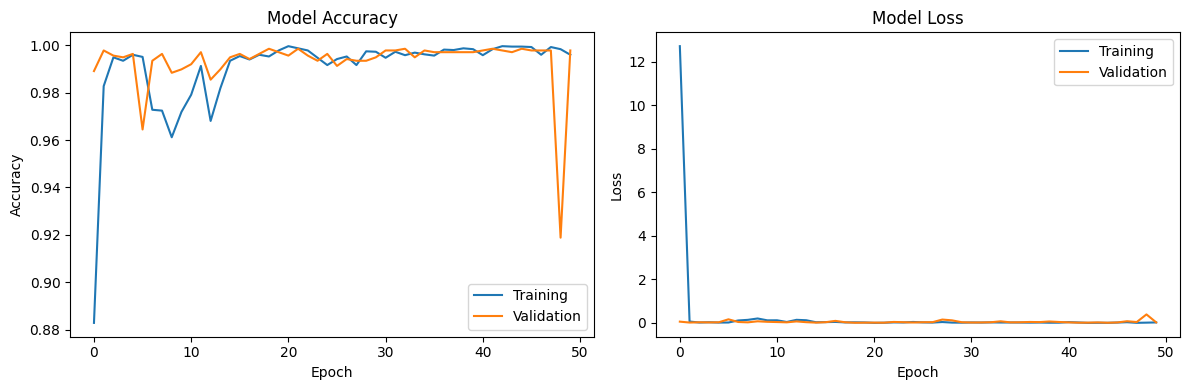

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step 


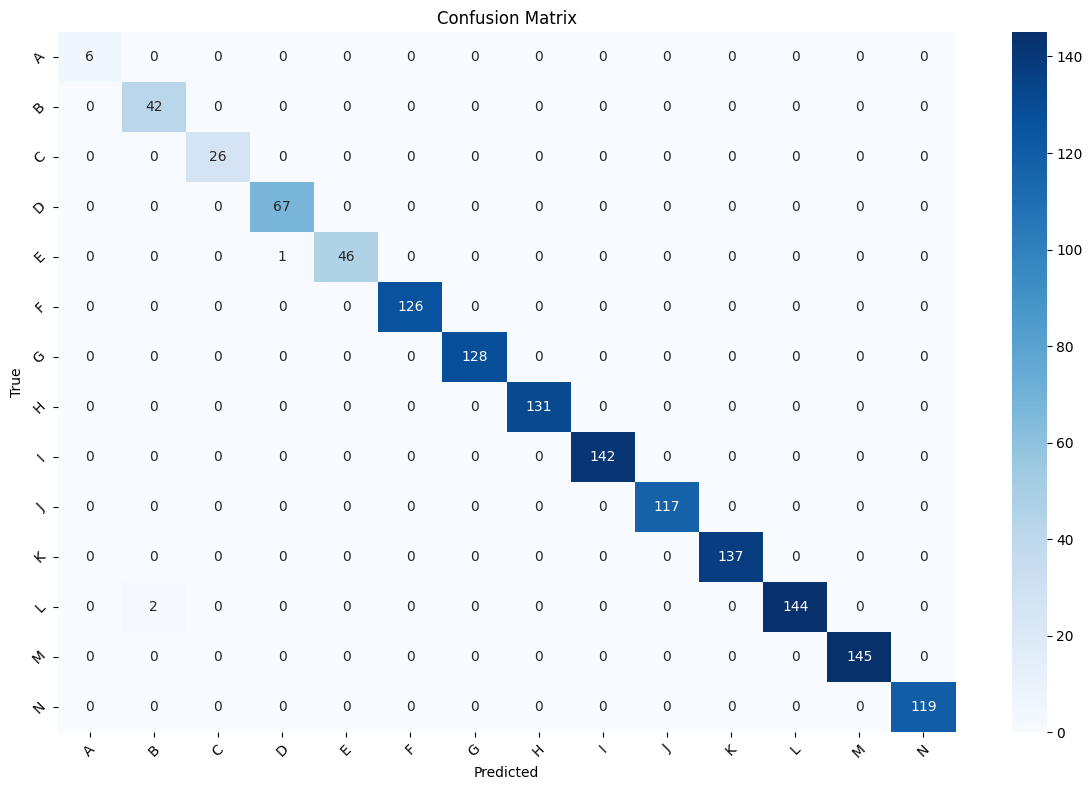


Saving model and metadata...
Model and metadata saved to saved_models\model_20241225_035333

Training completed successfully!
Final test accuracy: 99.78%
Final test loss: 0.0250

Saved files in saved_models\model_20241225_035333
- gesture_model/: Trained model
- label_encoder.pkl: Label encoder
- class_names.json: Class names
- training_history.png: Training plots
- confusion_matrix.png: Confusion matrix


In [8]:
if __name__ == "__main__":
    dataset_dir = "C:/Users/Pranav/Desktop/Dataset"
    save_dir = "C:/Users/Pranav/Downloads/Model"
    # Create timestamp for model versioning
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join('saved_models', f"model_{timestamp}")
    os.makedirs(save_dir, exist_ok=True)
    
    print("\nInitializing training...")
    print(f"Training data directory: {dataset_dir}")
    print(f"Model will be saved to: {save_dir}")
    
    # Initialize and train model
    recognizer = HandGestureRecognizer()
    
    print("\nPreparing dataset...")
    X_images, X_landmarks, y = recognizer.prepare_dataset(dataset_dir)
    
    # Encode labels
    recognizer.label_encoder = LabelEncoder()
    y_encoded = recognizer.label_encoder.fit_transform(y)
    y_onehot = tf.keras.utils.to_categorical(y_encoded)
    
    # Split dataset
    X_images_train, X_images_test, X_landmarks_train, X_landmarks_test, y_train, y_test = train_test_split(
        X_images, X_landmarks, y_onehot, test_size=0.2, random_state=42
    )
    
    print("\nCreating and compiling model...")
    recognizer.model = create_model()
    recognizer.model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    print("\nStarting training...")
    history = recognizer.model.fit(
        [X_images_train, X_landmarks_train],
        y_train,
        validation_data=([X_images_test, X_landmarks_test], y_test),
        epochs=50,
        batch_size=32
    )
    
    # Generate and save visualizations
    print("\nGenerating visualizations...")
    plot_training_history(history, save_dir)
    
    y_pred = recognizer.model.predict([X_images_test, X_landmarks_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    plot_confusion_matrix(
        y_test_classes, 
        y_pred_classes, 
        recognizer.label_encoder.classes_,
        save_dir
    )
    
    # Save model and metadata
    print("\nSaving model and metadata...")
    recognizer.save_model(save_dir)
    
    # Print final metrics
    test_loss, test_accuracy = recognizer.model.evaluate(
        [X_images_test, X_landmarks_test],
        y_test,
        verbose=0
    )
    print("\nTraining completed successfully!")
    print(f"Final test accuracy: {test_accuracy:.2%}")
    print(f"Final test loss: {test_loss:.4f}")
    print("\nSaved files in", save_dir)
    print("- gesture_model/: Trained model")
    print("- label_encoder.pkl: Label encoder")
    print("- class_names.json: Class names")
    print("- training_history.png: Training plots")
    print("- confusion_matrix.png: Confusion matrix")

In [9]:
 recognizer.model.save('hand_gesture_recognition.keras')

In [10]:
recognizer.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 63)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 57600)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 57664)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  7,381,120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 14)        │      1,806 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,256,300 (84.90 MB)

 Trainable params: 7,418,766 (28.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,837,534 (56.60 MB)